<a href="https://colab.research.google.com/github/YanghuiWu/MV-Hat/blob/main/transfer_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/Colab Notebooks/Hats/FinalData/
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Hats/FinalData
Data_Full/     HumanOnly.csv           vgg16_hats_only.pt
Data_Full.csv  lenet_hats.pt           vgg16_hats.pt
HatsOnly/      pytorch_dataset.py      vgg16_human_imagenet.pt
HatsOnly.csv   ReadMe.txt              vgg16_human_only.pt
HumanOnly/     vgg16_hats_imagenet.pt  vgg16_imagenet.pt


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#from pytorch_dataset import HatsDataset
import torch.optim as optim

# for pretrained model
import torchvision.models as models

In [ ]:
# for data prep
import os
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
import pickle

In [ ]:
class HatsDataset(Dataset):
    def __init__(self, csv_file, root_dir,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))

        if self.transform:
            image = self.transform(image)
        return (image,y_label)

In [ ]:
in_channel = 3
num_class = 15
learning_rate = 1e-3
batch_size = 16
num_epochs = 50

# Prepare Dataset
# for transfer learning, images are resized to 224*224

tf = transforms.Compose([transforms.ToPILImage(),transforms.Resize((224, 224)),transforms.ToTensor()])

# tf = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])



mixset = HatsDataset(csv_file='Data_Full.csv', root_dir='Data_Full', transform = tf)  #8779
hatset = HatsDataset(csv_file='HatsOnly.csv', root_dir='HatsOnly', transform = tf)  #7139
humanset = HatsDataset(csv_file='HumanOnly.csv', root_dir='HumanOnly', transform = tf)

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


mix_trainset, mix_testset = torch.utils.data.random_split(mixset, [int(0.8*len(mixset)), len(mixset) - int(0.8*len(mixset))])
hat_trainset, hat_testset = torch.utils.data.random_split(hatset, [int(0.8*len(hatset)), len(hatset) - int(0.8*len(hatset))])
human_trainset, human_testset = torch.utils.data.random_split(humanset, [int(0.8*len(humanset)), len(humanset) - int(0.8*len(humanset))])

classes = ('baseballcap', 'BikeHelmet', 'BucketHat', 'CowboyHat',
           'FeltHat', 'FireFighterHat', 'FlatCap', 'GraduationCap', 'Heaterhat', 'MilitaryHelmet',
           'MotorCycle Helmet', 'Police Hat', 'SateftyHelmet', 'TopHat', 'beanie')

In [ ]:





### ONLY CHANGE THIS
trainset = hat_trainset
testset = hat_testset

checkpoint = "vgg16_imagenet.pt"
### TO TEST ON DIFFERENT DATASETS





trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/

model = models.vgg16(pretrained=True)
dropout = 0.5
num_classes = 15

model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(p=dropout),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(p=dropout),
    nn.Linear(4096, num_classes),
)

model = model.to(device=device)
criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Training
model.train()
losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)    
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # print loss every epoch
    print(f'[Epoch: {epoch + 1} loss: {running_loss / len(trainloader)}')
    losses.append(running_loss / len(trainloader))
    running_loss = 0.0

print('Finished Training')

[Epoch: 1 loss: 2.044405899294952
[Epoch: 2 loss: 0.939999429618611
[Epoch: 3 loss: 0.5981742288468599
[Epoch: 4 loss: 0.44586484924647485
[Epoch: 5 loss: 0.33152419840003927
[Epoch: 6 loss: 0.2348187307433254
[Epoch: 7 loss: 0.17447819899120667
[Epoch: 8 loss: 0.14429436659072564
[Epoch: 9 loss: 0.10791423951056511
[Epoch: 10 loss: 0.08868328535522357
[Epoch: 11 loss: 0.07543620182604317
[Epoch: 12 loss: 0.060421233328869006
[Epoch: 13 loss: 0.0598003325945729
[Epoch: 14 loss: 0.045380965514119624
[Epoch: 15 loss: 0.0461012769768638
[Epoch: 16 loss: 0.04481444042754824
[Epoch: 17 loss: 0.04406188127385186
[Epoch: 18 loss: 0.030288206299235204
[Epoch: 19 loss: 0.03770183555171884
[Epoch: 20 loss: 0.030238226839049042
[Epoch: 21 loss: 0.030545508676006868
[Epoch: 22 loss: 0.028603396561069815
[Epoch: 23 loss: 0.029211722964710158
[Epoch: 24 loss: 0.03288109142672243
[Epoch: 25 loss: 0.026166840798987196
[Epoch: 26 loss: 0.02450763868054149
[Epoch: 27 loss: 0.022874048454239435
[Epoch: 2

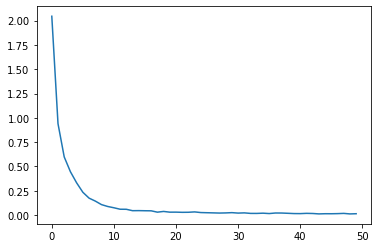

In [ ]:
torch.save(model.state_dict(), checkpoint)
plt.plot(losses)

In [ ]:
correct = 0
total = 0

model.eval() # Turn to evaluation mode to ignore dropout

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # images = images.to('cpu')
        # labels = labels.to('cpu')
        images = images.to(device = device)
        labels = labels.to(device = device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the model on the validation images: {100 * correct // total} %')

Accuracy of the model on the validation images: 87 %
